# Convolutional Neural Networks

Notebook by Corey Adams, some modifications by Bethany Lusch

Up until transformers, convolutions were *the* state of the art in computer vision.  In many ways and applications they still are!

Large Language Models, which are what we'll focus on the rest of the series after this lecture, are really good at ordered, *tokenized data.  But there is lots of data that isn't _implicitly_ ordered like `images`, and their more general cousins `graphs`.

Today's lecture focuses on computer vision models, and particularly on convolutional neural networks.  There are a ton of applications you can do with these, and not nearly enough time to get into them.  Check out the extra references file to see some publications to get you started if you want to learn more.

Tip: this notebook is much faster on the GPU!


## Convolutional Networks: A brief historical context

![ImageNet Accuracy by Yearh](ImageNet.png)

[reference](https://www.researchgate.net/publication/332452649_A_Roadmap_for_Foundational_Research_on_Artificial_Intelligence_in_Medical_Imaging_From_the_2018_NIHRSNAACRThe_Academy_Workshop)

In [3]:
import torch, torchvision

# Convolutional Building Blocks

We're going to go through some examples of building blocks for convolutional networks.  To help illustate some of these, let's use an image for examples:


In [4]:
from PIL import Image
# wget line useful in Google Colab
! wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/03_advanced_neural_networks/ALCF-Staff.jpg
alcf_image = Image.open("ALCF-Staff.jpg")

--2024-11-26 06:23:41--  https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/03_advanced_neural_networks/ALCF-Staff.jpg
Resolving proxy.alcf.anl.gov (proxy.alcf.anl.gov)... 140.221.69.69
Connecting to proxy.alcf.anl.gov (proxy.alcf.anl.gov)|140.221.69.69|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 417835 (408K) [image/jpeg]
Saving to: ‘ALCF-Staff.jpg.4’

ALCF-Staff.jpg.4    100%[===================>] 408.04K  --.-KB/s    in 0.005s  

2024-11-26 06:23:41 (76.7 MB/s) - ‘ALCF-Staff.jpg.4’ saved [417835/417835]



In [ ]:
from matplotlib import pyplot as plt
figure = plt.figure(figsize=(20,20))
plt.imshow(alcf_image)
plt.show()

## Convolutions

Convolutions are a restriction of - and a specialization of - dense linear layers.  A convolution of an image produces another image, and each output pixel is a function of only it's local neighborhood of points.  This is called an _inductive bias_ and is a big reason why convolutions work for image data: neighboring pixels are correlated and you can operate on just those pixels at a time.

See examples of convolutions [here](https://github.com/vdumoulin/conv_arithmetic)

![image-2.png](conv_eqn.png)

![image.png](conv.png)


In [ ]:
# Let's apply a convolution to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)

# Create a random convolution:
# shape is: (channels_in, channels_out, kernel_x, kernel_y)
conv_random = torch.rand((3,3,15,15))

alcf_rand = torch.nn.functional.conv2d(alcf_tensor, conv_random)
alcf_rand = (1./alcf_rand.max()) * alcf_rand
print(alcf_rand.shape)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Normalization

![Batch Norm](batch_norm.png)
Reference: [Normalizations](https://arxiv.org/pdf/1903.10520.pdf)

Normalization is the act of transforming the mean and moment of your data to standard values (usually 0.0 and 1.0).  It's particularly useful in machine learning since it stabilizes training, and allows higher learning rates.

![Batch Normalization accelerates training](batch_norm_effect.png)

Reference: [Batch Norm](https://arxiv.org/pdf/1502.03167.pdf)


In [ ]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.normalize(alcf_tensor)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)



## Downsampling (And upsampling)

Downsampling is a critical component of convolutional and many vision models.  Because of the local-only nature of convolutional filters, learning large-range features can be too slow for convergence.  Downsampling of layers can bring information from far away closer, effectively changing what it means to be "local" as the input to a convolution.

![Convolutional Pooling](conv_pooling.png "Pooling")

[Reference](https://www.researchgate.net/publication/333593451_Application_of_Transfer_Learning_Using_Convolutional_Neural_Network_Method_for_Early_Detection_of_Terry's_Nail)



In [ ]:
# Let's apply a normalization to the ALCF Staff photo:
alcf_tensor = torchvision.transforms.ToTensor()(alcf_image)

# Reshape the tensor to have a batch size of 1:
alcf_tensor = alcf_tensor.reshape((1,) + alcf_tensor.shape)


alcf_rand = torch.nn.functional.max_pool2d(alcf_tensor, 2)
alcf_rand = alcf_rand.reshape(alcf_rand.shape[1:])

print(alcf_tensor.shape)

rand_image = alcf_rand.permute((1,2,0)).cpu()

figure = plt.figure(figsize=(20,20))

plt.imshow(rand_image)


## Residual Connections

One issue, quickly encountered when making convolutional networks deeper and deeper, is the "Vanishing Gradients" problem.  As layers were stacked on top of each other, the size of updates dimished at the earlier layers of a convolutional network.  The paper "Deep Residual Learning for Image Recognition" solved this by introduction "residual connections" as skip layers.


Reference: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

![Residual Layer](residual_layer.png)


Compare the performance of the models before and after the introduction of these layers:

![Resnet Performance vs. Plain network performance](resnet_comparison.png)

If you have time to read only one paper on computer vision, make it this one!  Resnet was the first model to beat human accuracy on ImageNet and is one of the most impactful papers in AI ever published.

# Building a ConvNet

In this section we'll build and apply a conv net to the mnist dataset.  The layers here are loosely based off of the ConvNext architecture.  Why?  Because we're getting into LLM's soon, and this ConvNet uses LLM features.  ConvNext is an update to the ResNet architecture that outperforms it.

[ConvNext](https://arxiv.org/abs/2201.03545)


The dataset here is CIFAR-10 - slightly harder than MNIST but still relatively easy and computationally tractable.

In [6]:
from torchvision.transforms import v2
training_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=True,
    transform=v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomResizedCrop(size=32, scale=[0.85,1.0], antialias=False),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    ])
)

test_data = torchvision.datasets.CIFAR10(
    # Polaris: root="/lus/eagle/projects/datasets/CIFAR-10/",
    # Polaris: download=False,
    root="data",
    download=True,
    train=False,
    transform=torchvision.transforms.ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=True, 
    num_workers=2)
val_dataloader = torch.utils.data.DataLoader(validation_data, 
    batch_size=batch_size, 
    pin_memory=True,
    shuffle=False, 
    num_workers=2)

/soft/applications/conda/2024-08-08/mconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

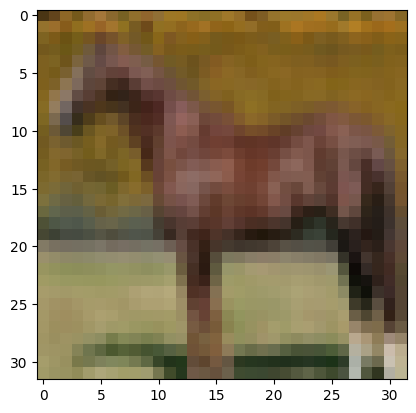

In [8]:
batch, (X, Y) = next(enumerate(train_dataloader))
plt.imshow(X[0].cpu().permute((1,2,0))); plt.show()

This code below is important as our models get bigger: this is wrapping the pytorch data loaders to put the data onto the GPU!

In [9]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


def preprocess(x, y):
    # CIFAR-10 is *color* images so 3 layers!
    return x.view(-1, 3, 32, 32).to(dev), y.to(dev)


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for b in self.dl:
            yield (self.func(*b))


train_dataloader = WrappedDataLoader(train_dataloader, preprocess)
val_dataloader = WrappedDataLoader(val_dataloader, preprocess)

In [10]:
from torch import nn


class Downsampler(nn.Module):

    def __init__(self, in_channels, out_channels, shape, stride=2):
        super(Downsampler, self).__init__()

        self.norm = nn.LayerNorm([in_channels, *shape])

        self.downsample = nn.Conv2d(
            in_channels=in_channels, 
            out_channels=out_channels,
            kernel_size = stride,
            stride = stride,
        )
    
    def forward(self, inputs):


        return self.downsample(self.norm(inputs))
        
        

class ConvNextBlock(nn.Module):
    """This block of operations is loosely based on this paper:

    """


    def __init__(self, in_channels, shape):
        super(ConvNextBlock, self).__init__()

        # Depthwise, seperable convolution with a large number of output filters:
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=in_channels, 
                                     groups=in_channels,
                                     kernel_size=[7,7],
                                     padding='same' )

        self.norm = nn.LayerNorm([in_channels, *shape])

        # Two more convolutions:
        self.conv2 = nn.Conv2d(in_channels=in_channels, 
                                     out_channels=4*in_channels,
                                     kernel_size=1)

        self.conv3 = nn.Conv2d(in_channels=4*in_channels, 
                                     out_channels=in_channels,
                                     kernel_size=1
                                     )


    def forward(self, inputs):
        x = self.conv1(inputs)

        # The normalization layer:
        x = self.norm(x)

        x = self.conv2(x)

        # The non-linear activation layer:
        x = torch.nn.functional.gelu(x)

        x = self.conv3(x)

        # This makes it a residual network:
        return x + inputs
    

class Classifier(nn.Module):


    def __init__(self, n_initial_filters, n_stages, blocks_per_stage):
        super(Classifier, self).__init__()

        # This is a downsampling convolution that will produce patches of output.

        # This is similar to what vision transformers do to tokenize the images.
        self.stem = nn.Conv2d(in_channels=3,
                                    out_channels=n_initial_filters,
                                    kernel_size=1,
                                    stride=1)
        
        current_shape = [32, 32]

        self.norm1 = nn.LayerNorm([n_initial_filters,*current_shape])
        # self.norm1 = WrappedLayerNorm()

        current_n_filters = n_initial_filters
        
        self.layers = nn.Sequential()
        for i, n_blocks in enumerate(range(n_stages)):
            # Add a convnext block series:
            for _ in range(blocks_per_stage):
                self.layers.append(ConvNextBlock(in_channels=current_n_filters, shape=current_shape))
            # Add a downsampling layer:
            if i != n_stages - 1:
                # Skip downsampling if it's the last layer!
                self.layers.append(Downsampler(
                    in_channels=current_n_filters, 
                    out_channels=2*current_n_filters,
                    shape = current_shape,
                    )
                )
                # Double the number of filters:
                current_n_filters = 2*current_n_filters
                # Cut the shape in half:
                current_shape = [ cs // 2 for cs in current_shape]
            


        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(current_n_filters),
            nn.Linear(current_n_filters, 10)
        )
        # self.norm2 = nn.InstanceNorm2d(current_n_filters)
        # # This brings it down to one channel / class
        # self.bottleneck = nn.Conv2d(in_channels=current_n_filters, out_channels=10, 
        #                                   kernel_size=1, stride=1)

    def forward(self, inputs):

        x = self.stem(inputs)
        # Apply a normalization after the initial patching:
        x = self.norm1(x)

        # Apply the main chunk of the network:
        x = self.layers(x)

        # Normalize and readout:
        x = nn.functional.avg_pool2d(x, x.shape[2:])
        x = self.head(x)

        return x



        # x = self.norm2(x)
        # x = self.bottleneck(x)

        # # Average pooling of the remaining spatial dimensions (and reshape) makes this label-like:
        # return nn.functional.avg_pool2d(x, kernel_size=x.shape[-2:]).reshape((-1,10))

In [ ]:
!pip install torchinfo # if not on Polaris

In [11]:
model = Classifier(32, 4, 2).to(device=dev)

from torchinfo import summary

print(summary(model, input_size=(batch_size, 3, 32, 32)))


Layer (type:depth-idx)                   Output Shape              Param #
Classifier                               [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 32, 32]         128
├─LayerNorm: 1-2                         [128, 32, 32, 32]         65,536
├─Sequential: 1-3                        [128, 256, 4, 4]          --
│    └─ConvNextBlock: 2-1                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-2               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-3                  [128, 128, 32, 32]        4,224
│    │    └─Conv2d: 3-4                  [128, 32, 32, 32]         4,128
│    └─ConvNextBlock: 2-2                [128, 32, 32, 32]         --
│    │    └─Conv2d: 3-5                  [128, 32, 32, 32]         1,600
│    │    └─LayerNorm: 3-6               [128, 32, 32, 32]         65,536
│    │    └─Conv2d: 3-7                  [128, 128, 32, 32] 

In [12]:
def evaluate(dataloader, model, loss_fn, val_bar):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:

            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            val_bar.update()
            
    loss /= num_batches
    correct /= (size*batch_size)
    
    accuracy = 100*correct
    return accuracy, loss

In [13]:
def train_one_epoch(dataloader, model, loss_fn, optimizer, progress_bar):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()      

        progress_bar.update()

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

In [15]:
from tqdm.notebook import tqdm


epochs = 30
for j in range(epochs):
    with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Train Epoch {j}") as train_bar:
        train_one_epoch(train_dataloader, model, loss_fn, optimizer, train_bar)
    
    # checking on the training & validation loss & accuracy 
    # for training data - only once every 5 epochs (takes a while) 
    if j % 5 == 0:
        with tqdm(total=len(train_dataloader), position=0, leave=True, desc=f"Validate (train) Epoch {j}") as train_eval:
            acc, loss = evaluate(train_dataloader, model, loss_fn, train_eval)
            print(f"Epoch {j}: training loss: {loss:.3f}, accuracy: {acc:.3f}")
            
    with tqdm(total=len(val_dataloader), position=0, leave=True, desc=f"Validate Epoch {j}") as val_bar:
    
        acc_val, loss_val = evaluate(val_dataloader, model, loss_fn, val_bar)
        print(f"Epoch {j}: validation loss: {loss_val:.3f}, accuracy: {acc_val:.3f}")
    

Train Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0: training loss: 2.242, accuracy: 17.150


Validate Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 0: validation loss: 2.245, accuracy: 17.138


Train Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1: validation loss: 2.049, accuracy: 23.586


Train Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2: validation loss: 1.961, accuracy: 28.194


Train Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3: validation loss: 1.931, accuracy: 28.649


Train Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4: validation loss: 1.898, accuracy: 30.973


Train Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: training loss: 1.882, accuracy: 32.066


Validate Epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5: validation loss: 1.889, accuracy: 32.051


Train Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6: validation loss: 1.802, accuracy: 34.800


Train Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7: validation loss: 1.770, accuracy: 35.127


Train Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8: validation loss: 1.726, accuracy: 36.719


Train Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9: validation loss: 1.701, accuracy: 38.074


Train Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: training loss: 1.709, accuracy: 39.327


Validate Epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10: validation loss: 1.711, accuracy: 38.776


Train Epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11: validation loss: 1.657, accuracy: 39.270


Train Epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12: validation loss: 1.653, accuracy: 39.537


Train Epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13: validation loss: 1.678, accuracy: 39.389


Train Epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14: validation loss: 1.650, accuracy: 40.051


Train Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 15: training loss: 1.616, accuracy: 42.050


Validate Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15: validation loss: 1.610, accuracy: 42.029


Train Epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16: validation loss: 1.565, accuracy: 42.840


Train Epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17: validation loss: 1.578, accuracy: 43.206


Train Epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18: validation loss: 1.546, accuracy: 43.681


Train Epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19: validation loss: 1.542, accuracy: 43.730


Train Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 20: training loss: 1.499, accuracy: 46.069


Validate Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20: validation loss: 1.495, accuracy: 45.609


Train Epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 21: validation loss: 1.545, accuracy: 43.523


Train Epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 22: validation loss: 1.488, accuracy: 46.766


Train Epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 23: validation loss: 1.555, accuracy: 43.335


Train Epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 24: validation loss: 1.483, accuracy: 45.204


Train Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Validate (train) Epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 25: training loss: 1.471, accuracy: 46.950


Validate Epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 25: validation loss: 1.474, accuracy: 46.677


Train Epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 26: validation loss: 1.507, accuracy: 44.719


Train Epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 27: validation loss: 1.466, accuracy: 46.232


Train Epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 28: validation loss: 1.436, accuracy: 47.903


Train Epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

Validate Epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 29: validation loss: 1.433, accuracy: 48.072


# Homework 1:

In this notebook, we've learned about some basic convolutional networks and trained one on CIFAR-10 images.  It did ... OK.  There is significant overfitting of this model.  There are some ways to address that, but we didn't have time to get into that in this session.

Meanwhile, your homework (part 1) for this week is to try to train the model again but with a different architecture.  Change one or more of the following:
- The number of convolutions between downsampling
- The number of filters in each layer
- The initial "patchify" layer
- Another hyper-parameter of your choosing


And compare your final validation accuracy to the accuracy shown here.  Can you beat the validation accuracy shown?

For full credit on the homework, you need to show (via text, or make a plot) the training and validation data sets' performance (loss and accuracy) for all the epochs you train.  You also need to explain, in several sentences, what you changed in the network and why you think it makes a difference.